In [2]:
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
add_to_cart_df = pd.read_csv("retailrocket_dataset/add_to_cart_ecommerce.dat", usecols=["visitorid", "itemid"], sep="\t")
purchase_df = pd.read_csv("retailrocket_dataset/purchase_ecommerce.dat", usecols=["visitorid", "itemid"], sep="\t")
view_df = pd.read_csv("retailrocket_dataset/view_ecommerce.dat", usecols=["visitorid", "itemid"], sep="\t")

In [4]:
add_to_cart_df

,visitorid,itemid
0,1,1
1,1,16
2,2,21
3,4,60
4,7,103
...,...,...
9023,3425,4635
9024,3425,5463
9025,3425,7887
9026,3429,1826


Let's use this implicit feedback information to construct weights depending on "event" or user activity recorded. We have 3 events, which we can sort based on importance:
1. View
    - is the least important, so we assign it a weight of **1/5**
2. Add to cart
    - is second in importance, so we assign it a weight of **2/5**
3. Purchase
    - is the most importnat, so we assign it a weight of **3/5**

In [38]:
add_to_cart_df["score"] = 1/6
view_df["score"] = 2/6
purchase_df["score"] = 3/6

scoresDF = pd.concat([add_to_cart_df, purchase_df, view_df], ignore_index=True)
scoresDF

,visitorid,itemid,score
0,1,1,0.166667
1,1,16,0.166667
2,2,21,0.166667
3,4,60,0.166667
4,7,103,0.166667
...,...,...,...
92482,3431,8881,0.333333
92483,3431,8882,0.333333
92484,3431,8883,0.333333
92485,3431,8884,0.333333


In [39]:
scoresDF.itemid.unique().shape

(8885,)

In [40]:
scoresDF.visitorid.unique().shape

(3431,)

Let's sum the individual scores to get final score for each time by each user.

In [43]:
df = scoresDF.groupby(["visitorid", "itemid"]).sum()["score"].reset_index()
df

,visitorid,itemid,score
0,1,1,1.000000
1,1,2,0.333333
2,1,3,0.333333
3,1,4,0.333333
4,1,5,0.333333
...,...,...,...
79590,3431,8881,0.333333
79591,3431,8882,0.333333
79592,3431,8883,0.333333
79593,3431,8884,0.333333


<AxesSubplot: >

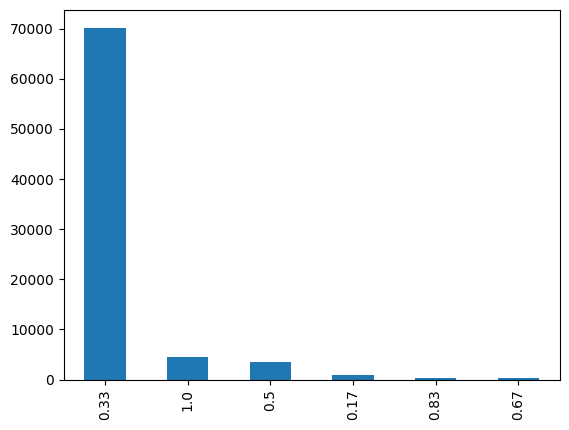

In [47]:
df.score.apply(lambda x: round(x, 2)).value_counts().plot(kind = "bar")

There are not many "purchases" or "add to cart" events in the reduced dataset (But neither in the original one.), which explains the dominance of lower scores (View events).

### Split Dataset 

In [48]:
train, test = train_test_split(df, test_size = 0.33, random_state = 56)
train.to_csv("train.dat", index=False, header=False, sep='\t')
test.to_csv("test.dat", index=False, header=False, sep='\t')

### Train and predict

In [49]:
from caserec.recommenders.item_recommendation.userknn import UserKNN

UserKNN("train.dat", "test.dat", "rank_userknn.dat", as_binary=True).compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > UserKNN Algorithm]

train data:: 3431 users and 8472 items (53328 interactions) | sparsity:: 99.82%
test data:: 3388 users and 7290 items (26267 interactions) | sparsity:: 99.89%

training_time:: 41.579913 sec
prediction_time:: 97.160100 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.141677	0.262028	0.289982	0.314318	


In [50]:
from caserec.recommenders.item_recommendation.itemknn import ItemKNN

ItemKNN("train.dat", "test.dat", "rank_itemknn.dat", as_binary=True).compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 3431 users and 8472 items (53328 interactions) | sparsity:: 99.82%
test data:: 3388 users and 7290 items (26267 interactions) | sparsity:: 99.89%

training_time:: 142.105714 sec
prediction_time:: 375.502720 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.088548	0.16819	0.19059	0.208274	


In [51]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular

MostPopular("train.dat", "test.dat", "rank_mostPopular.dat").compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > Most Popular]

train data:: 3431 users and 8472 items (53328 interactions) | sparsity:: 99.82%
test data:: 3388 users and 7290 items (26267 interactions) | sparsity:: 99.89%

prediction_time:: 92.484861 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.012102	0.02336	0.031176	0.04204	
